# SpoTwify

### Una breve presentazione di SpoTwify, realizzato da Giorgio Privitera (X81000515)
#### Progetto di Technologies for Advanced Programming, AA 2020/2021

## Idea

SpoTwify è un piccolo progetto che unisce informazioni provenienti da Spotify e Twitter, al fine di fornire un'idea generale dell'opinione publica riguardo nuove uscite e canzoni popolari sulla piattaforma di streaming musicale.

## Architettura

SpoTwify si serve di Zookeper, Kafka, Spark, Elastic Search e Kibana, e fa uso diretto di Spotipy e tweepy come librerie di python. Durante questa presentazione saranno mostrate porzioni di codice che svolgono le funzionalità descritte; tuttavia non si tratta di codice eseguibile poiché, per favorire la leggibilità, sono state omesse funzioni di servizio e chiamate a librerie.

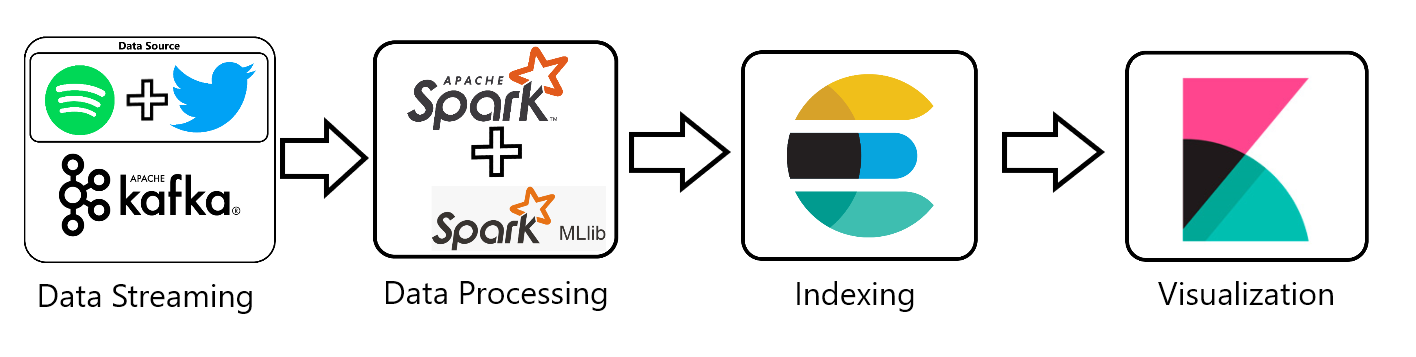

Il programma inizialmente prende in input i dati relativi alla playlist [Top 50 Global da Spotify](https://open.spotify.com/playlist/37i9dQZEVXbMDoHDwVN2tF) e cerca su Twitter tweet rilevanti che condividono le canzoni contenute in essa.

In [ ]:
# Extracts track info and returns a dictionary with keys {Artist, Song, URL}
def extract_track_info(spotifyTrack):
    track_artist = spotifyTrack["artists"][0]["name"]
    track_title = spotifyTrack["name"]
    track_url = spotifyTrack["external_urls"]["spotify"]
    track_info = {
        'Artist' : track_artist,
        'Title' : track_title,
        'URL' : track_url
    }
    return track_info

# Retrieves a list containing dictionaries with keys {Artist, Song, URL} for each song in the Top 50 Global Playlist from Spotify
def get_spotify_top50_playlist(spotifyInstance):
    top50_playlist = spotifyInstance.playlist(playlist_id = "37i9dQZEVXbMDoHDwVN2tF")
    playList = []
    for item in top50_playlist["tracks"]["items"]:
        playList.append(extract_track_info(item["track"]))
    return playList

I dati della playlist sono inseriti in una lista di dizionari, uno per canzone. Un dizionario è strutturato per contenere il nome dell'artista, il titolo della canzone e l'URL univoco della traccia su Spotify. In seguito si compie una ricerca tramite tweepyAPI.cursor() per trovare tutti i tweet che condividono i suddetti brani e si invia un json_output usando un KafkaProducer con topic "tweets". Purtroppo, poiché il dataset usato come training set contiene solo tweet in Inglese, la ricerca sarà eseguita solo in tale lingua, limitando la quantità di dati disponibile.

In [ ]:
kafkaProducer = KafkaProducer(bootstrap_servers = ['10.0.100.23:9092'],
                                value_serializer = lambda data:
                                json.dumps(data).encode("utf-8"))

def main():
    spotifyAPI = initializeSpotify()
    twitterAPI = initializeTwitter()
    print("Retrieving playlist...")
    top50_playlist = get_spotify_top50_playlist(spotifyAPI)
    print("{} Playlist retrieved".format(top50_playlist))
    
    sleep(3)
    
    print("Searching for tweets based on Spotify URLs...")
    json_artistField = "Artist"
    json_titleField = "Title"
    json_urlField = "URL"
    json_tweetField = "tweet"

    print("Looking for tweets about songs...")
    for song in top50_playlist:
        artist = song.get("Artist")
        title = song.get("Title")
        url = song.get("URL")
        tweetsQuery = tweepy.Cursor(twitterAPI.search, q = url, lang = "en").items()
        for tweet in tweetsQuery:
            json_output = '{"'+json_artistField+'":"'+artist+'","'+json_titleField+'":"'+title+'","'+json_urlField+'":"'+url+'","'+json_tweetField+'":"'+tweet.text+'}'
            kafkaProducer.send("tweets", value = json_output)
    print("Twitter search finished")

All'esecuzione di _kafkaPythonDataGatherer.sh_ il terminale chiederà di aprire un link per poter produrre un token per Spotipy: così facendo si è reindirizzati verso una pagina il cui URL contiene il codice di autorizzazione. Basta infatti copiarlo e incollarlo nel terminale per ricavare i dati.

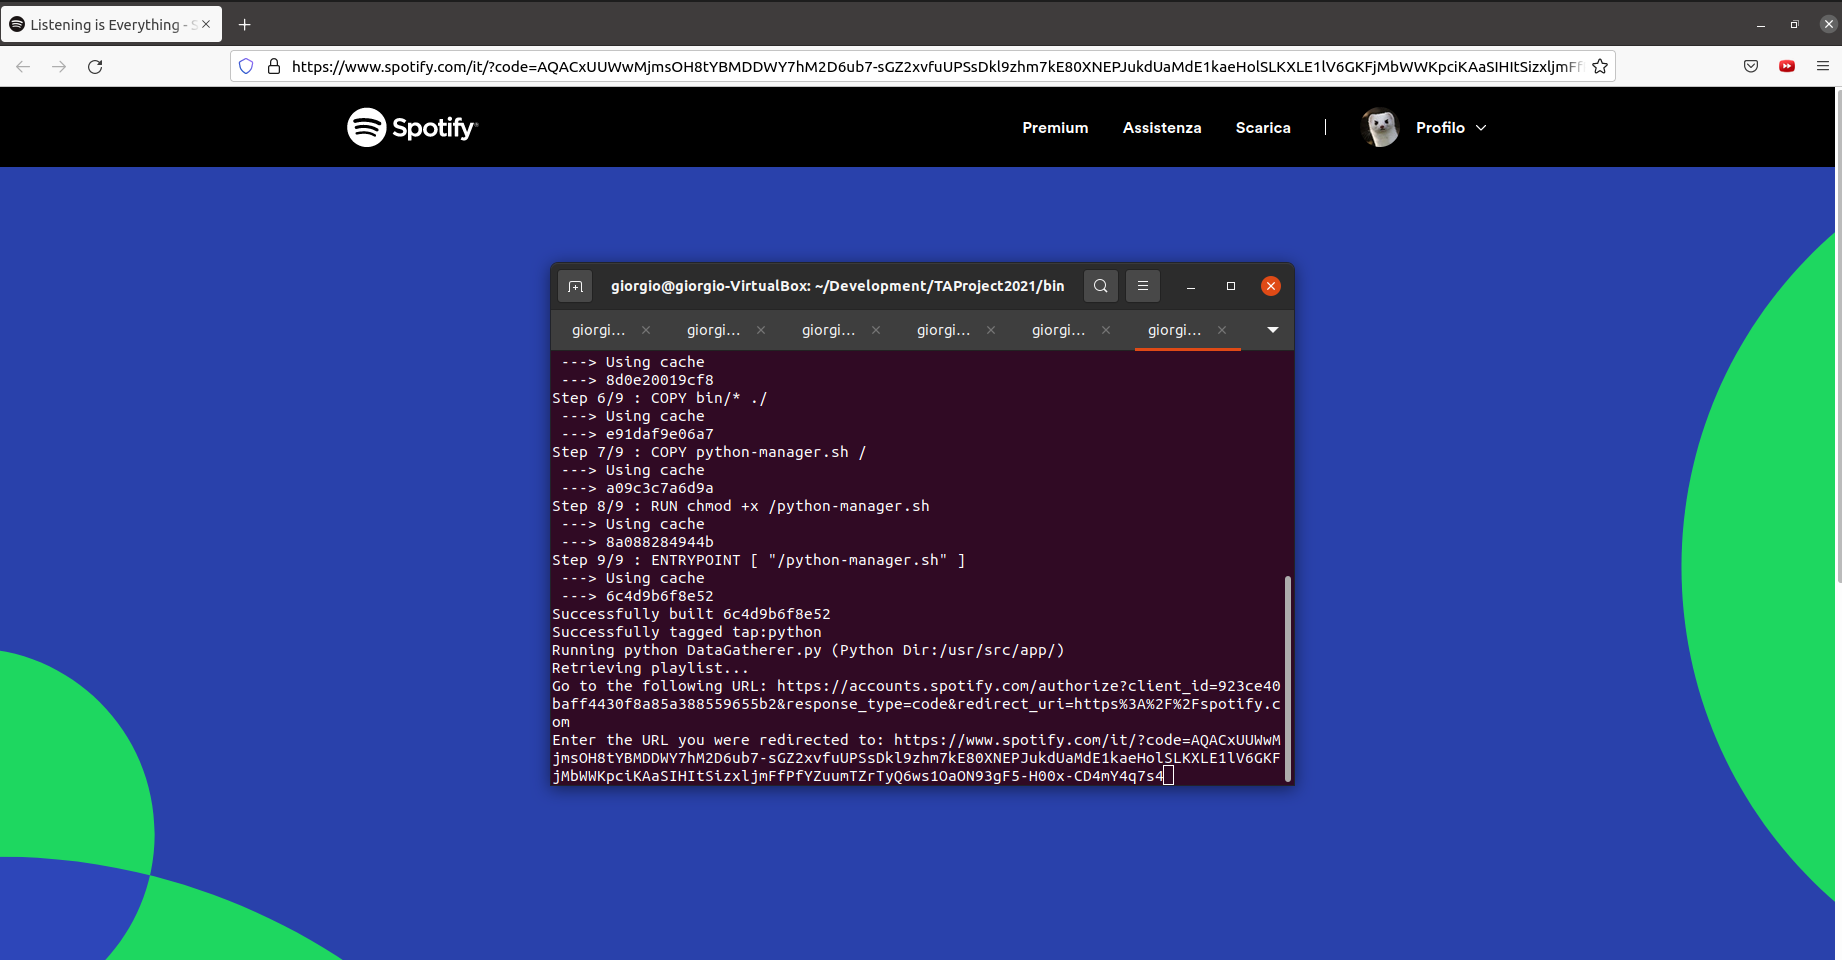

I messaggi del produttore sono trasmessi a Spark, così da applicare Sentiment Analysis relativo ai tweet e fornire una valutazione positiva (1.0) o negativa (0.0) del commento. Per il training è stato usato [Twitter Sentiment Analysis Dataset](http://thinknook.com/twitter-sentiment-analysis-training-corpus-dataset-2012-09-22/) che unisce i dati da Sentiment140 e Twitter Sentiment Corpus. Il dataset non è stato usato interamente per via della dimensione imponente, e il training è stato ristretto a 150000 elementi. La pipeline di elaborazione è composta da 3 stages: un tokenizer, uno stop words remover e un estrattore di features di testo. Per fornire le previsioni è stato scelto il modello della regressione logistica.

In [ ]:
# Training Set
def training():
    trainingSchema = tp.StructType([
        tp.StructField(name = 'ItemID', dataType = tp.IntegerType(), nullable = True),
        tp.StructField(name = 'Sentiment', dataType = tp.IntegerType(), nullable = True),
        tp.StructField(name = 'SentimentSource', dataType = tp.StringType(), nullable = True),
        tp.StructField(name = 'SentimentText', dataType = tp.StringType(), nullable = True)
    ])

    training_set = spark.read.csv('../tap/spark/dataset/Sentiment Analysis Dataset.csv',
                                schema = trainingSchema,
                                header = True,
                                sep = ',').limit(150000)
    training_set

    # Pipeline
    print("Creating ML pipeline...", "\n")
    stage_1 = RegexTokenizer(inputCol = 'SentimentText', outputCol = 'tokens', pattern = '\\W')
    stage_2 = StopWordsRemover(inputCol = 'tokens', outputCol = 'filtered_words')
    stage_3 = Word2Vec(inputCol = 'filtered_words', outputCol = 'vector', vectorSize = 100)
    model = LogisticRegression(featuresCol = 'vector', labelCol = 'Sentiment')
    pipeline = Pipeline(stages = [stage_1, stage_2, stage_3, model])
    print("Pipeline created", "\n")
    print("Creating logit model...", "\n")
    pipelineLRFit = pipeline.fit(training_set)
    print("Logit model created", "\n")

    return pipelineLRFit

pipelineLogit = training()

Spark legge ed elabora lo stream ricevuto nel modo seguente:

In [ ]:
# Spark
sc = SparkContext(appName = "PythonSparkSA")
spark = SparkSession(sc)
sc.setLogLevel("WARN")

# Kafka
kafkaServer = "kafkaServer:9092"
brokers = "10.0.100.23:9092"
topic = "tweets"

appSchema = tp.StructType([
    tp.StructField("Artist", tp.StringType(), True),
    tp.StructField("Title", tp.StringType(), True),
    tp.StructField("URL", tp.StringType(), True),
    tp.StructField("SentimentText", tp.StringType(), True)
])

def mapinfo(batchDF, batchID):
    print("******** foreach ********", batchID)
    valueRdd = batchDF.rdd.map(lambda x: x[1])
    print(valueRdd, "\n")
    strList = valueRdd.map(lambda x: json.loads(x)).collect() #list of strings with json value
    print("\n", strList, "\n")
    tupleList = []
    for string in strList:
        splitStr = string.split('","')
        artistStr = splitStr[0].split('":"', 1)[1]
        titleStr = splitStr[1].split('":"', 1)[1]
        urlStr = splitStr[2].split('":"', 1)[1]
        tweetStr = splitStr[3].split('":"', 1)[1]

        tuple = (artistStr, titleStr, urlStr, tweetStr[:len(tweetStr) - 2])
        tupleList.append(tuple)
    tweetDF = spark.createDataFrame(data = tupleList, schema = appSchema)
    transformedDF = pipelineLogit.transform(tweetDF).select('Artist', 'Title', 'URL', 'SentimentText', 'prediction')
    transformedDF.show(truncate = False)
    
print("Reading from Stream")
kafkaDataFrame = spark \
    .readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", kafkaServer) \
    .option("subscribe", topic) \
    .load()

df2 = kafkaDataFrame \
    .writeStream \
    .foreachBatch(mapinfo) \
    .start() \
    .awaitTermination()

I dati così elaborati sono passati ad ElasticSearch per indicizzazione, pronti per essere visualizzati da Kibana.

In [ ]:
# ElasticSearch
elastic_host = "10.0.100.51"
elastic_index = "twitter"
elastic_document = "_doc"

es_mapping = {
    "mappings": {
        "properties":
        {
            "Artist": {"type": "constant_keyword", "fielddata": True},
            "Title": {"type": "constant_keyword", "fielddata": True},
            "URL": {"type": "constant_keyword", "fielddata": True},
            "Tweet": {"type": "text", "fielddata": True},
            "Sentiment": {"type": "integer"}
        }
    }
}


es = Elasticsearch(hosts = elastic_host)

response = es.indices.create(
    index = elastic_index,
    body = es_mapping,
    ignore = 400 # Ignore Error 400 Index already exists
)

if 'acknowledged' in response:
    if response['acknowledged'] == True:
        print("Index mapping SUCCESS: ", response['index'])

Infine, si modifica mapinfo per trasmettere i dataframe ed indicizzarli.

In [ ]:
def mapinfo(batchDF, batchID):
    print("******** foreach ********", batchID)
    valueRdd = batchDF.rdd.map(lambda x: x[1])
    print(valueRdd, "\n")
    strList = valueRdd.map(lambda x: json.loads(x)).collect() #list of strings with json value
    print("\n", strList, "\n")
    tupleList = []
    for string in strList:
        splitStr = string.split('","')
        artistStr = splitStr[0].split('":"', 1)[1]
        titleStr = splitStr[1].split('":"', 1)[1]
        urlStr = splitStr[2].split('":"', 1)[1]
        tweetStr = splitStr[3].split('":"', 1)[1]

        tuple = (artistStr, titleStr, urlStr, tweetStr[:len(tweetStr) - 2])
        tupleList.append(tuple)
    tweetDF = spark.createDataFrame(data = tupleList, schema = appSchema)
    transformedDF = pipelineLogit.transform(tweetDF).select('Artist', 'Title', 'URL', 'SentimentText', 'prediction')
    transformedDF.show(truncate = False)

    transformedDF.write \
    .format("org.elasticsearch.spark.sql") \
    .mode("append") \
    .option("es.mapping.id", "URL") \
    .option("es.nodes", elastic_host).save(elastic_index)

I dati sono finalmente pronti per essere visualizzati tramite [Kibana](https://localhost:5061). Innanzitutto bisogna scegliere l'indice che sarà utilizzato: la pagina chiederà automaticamente di creare un Index Pattern (in alternativa bisogna cliccare su **Manage** e poi **Index Pattern**.

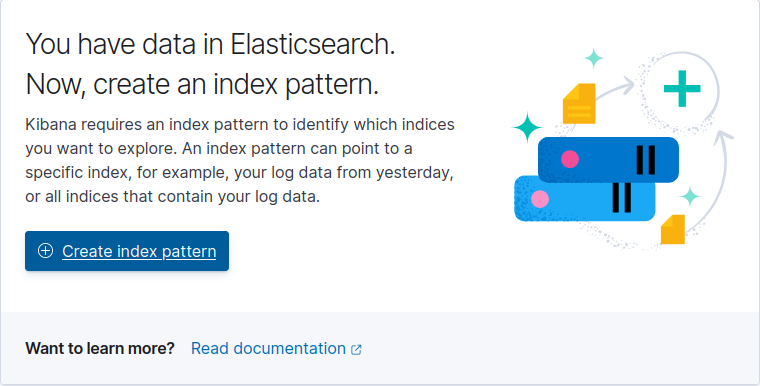

L'indice definito è twitter.

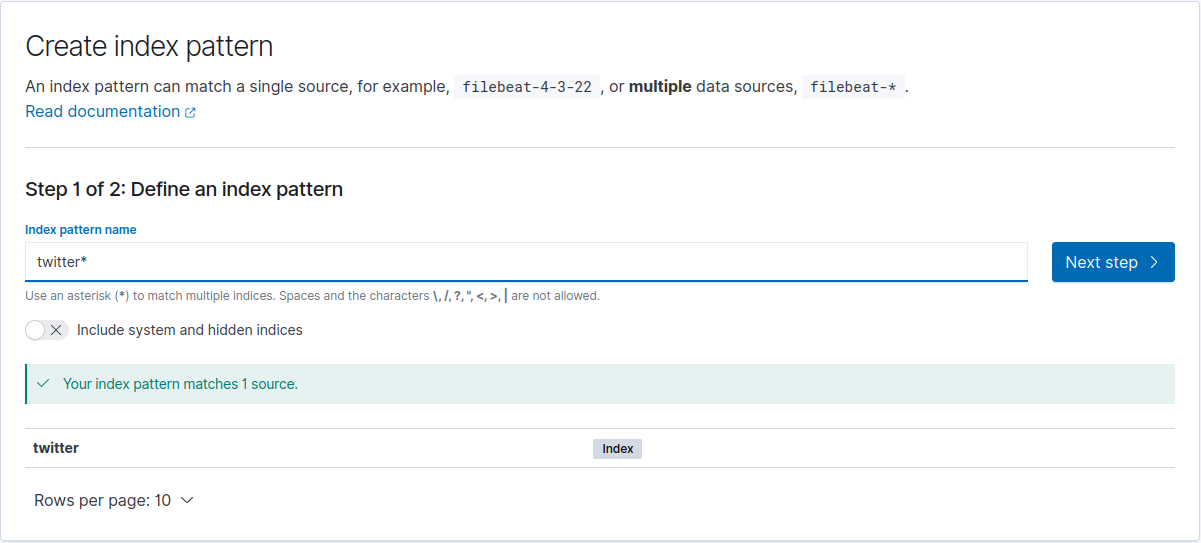

Una volta ricevuti i dati con _kafkaPythonDataGatherer.sh_ ed elaborati con _sparkStart.sh_, l'indice avrà questo aspetto:

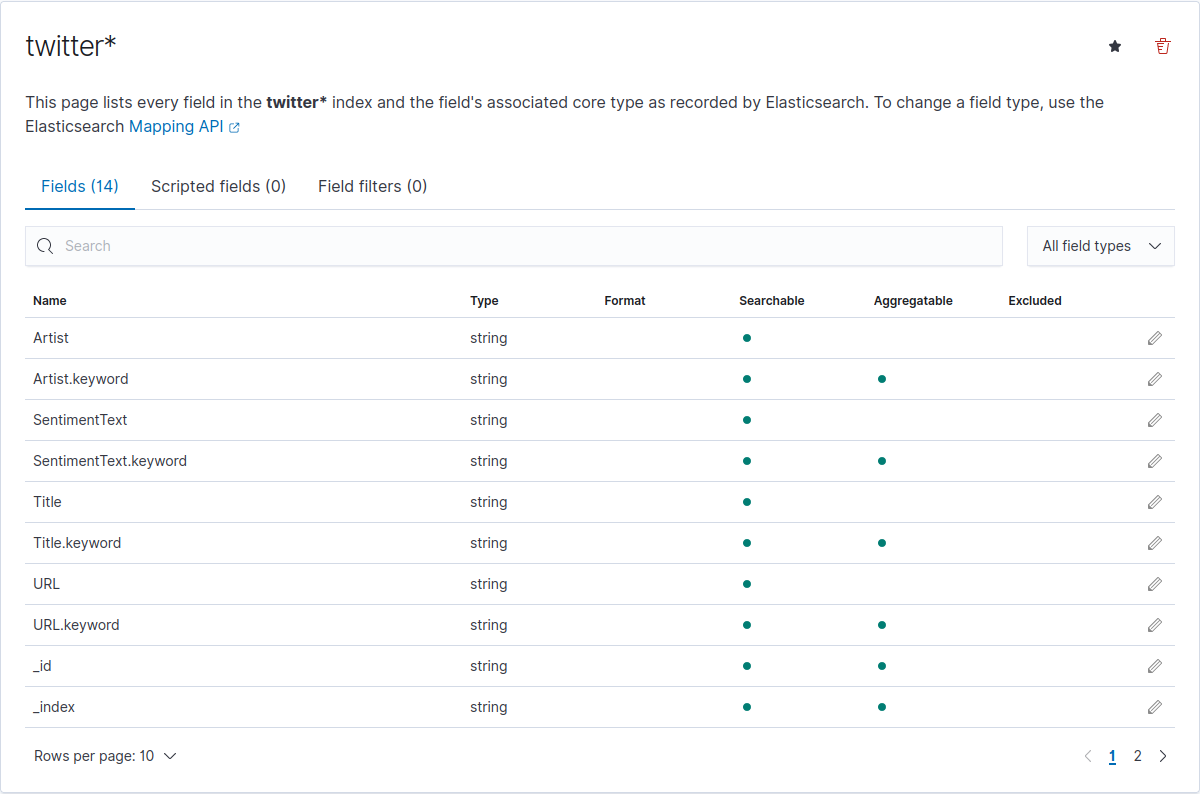

Un esempio di Dashboard può essere la seguente:

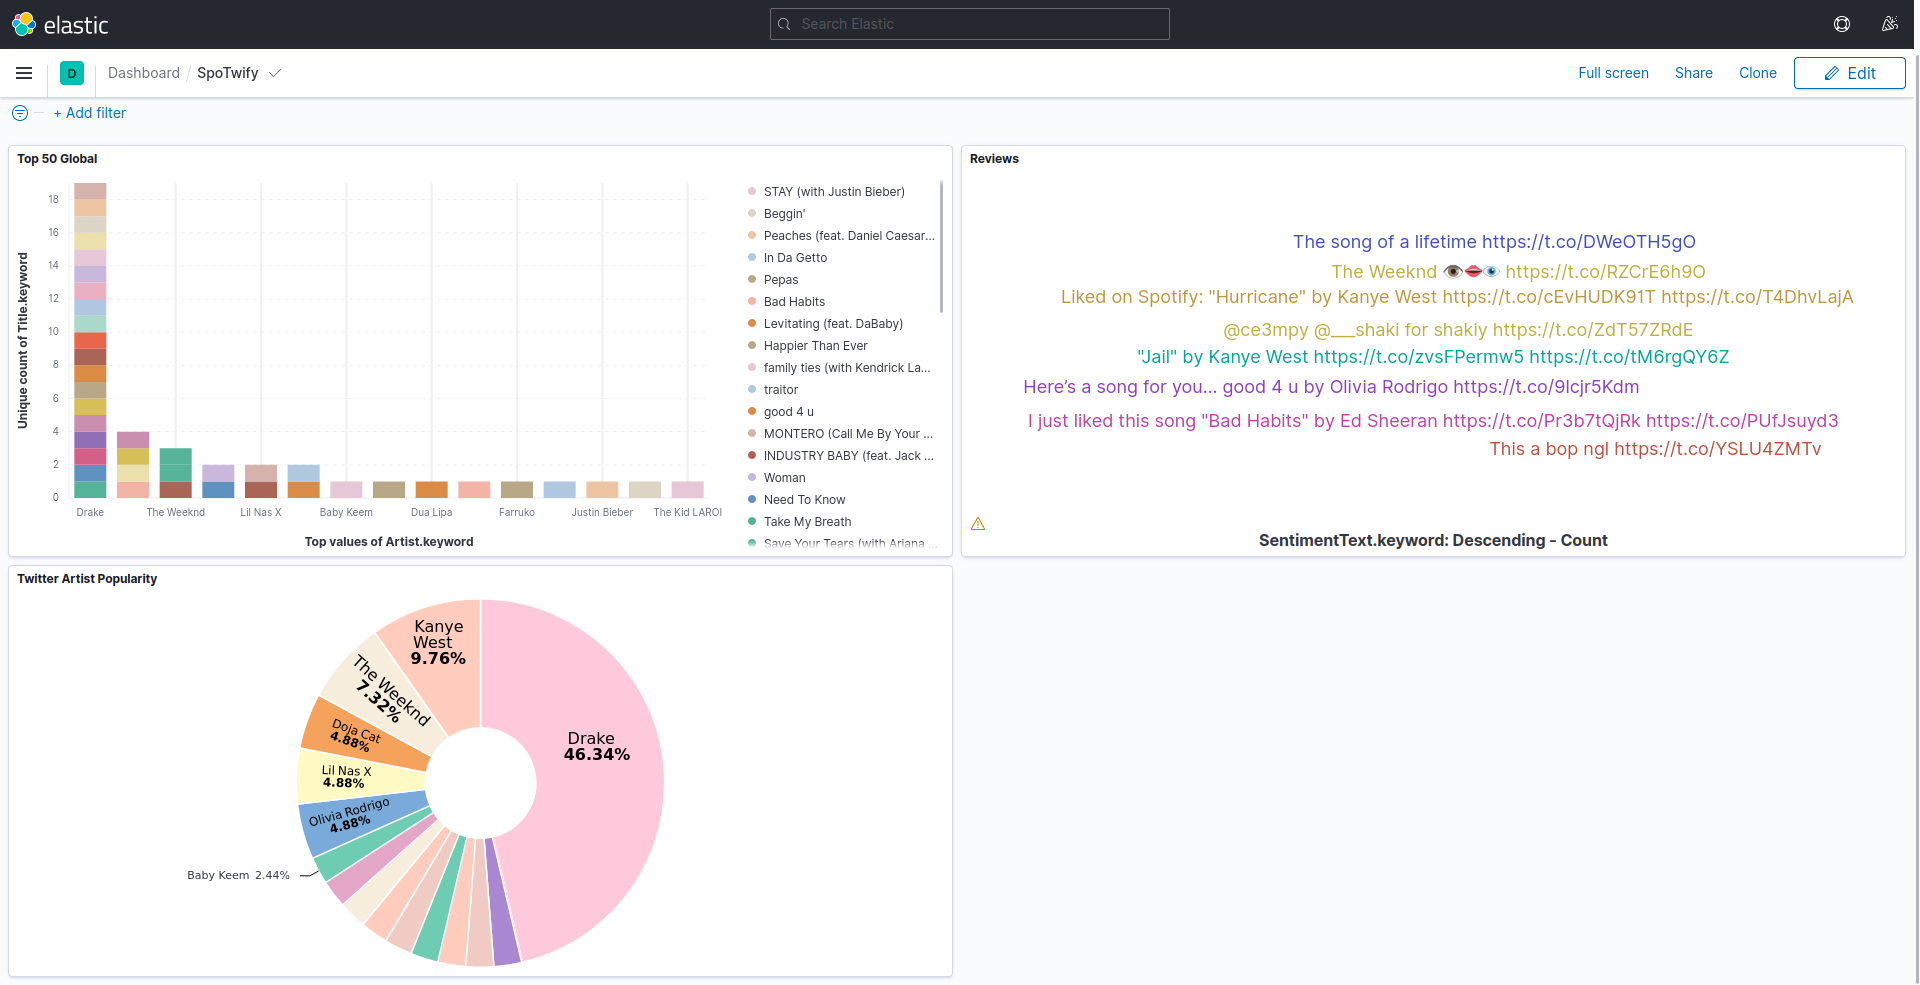

In senso orario si hanno: un istogramma che mostra la distribuzione degli Artisti e delle loro canzoni nella playlist esaminata; una word cloud da cui è possibile leggere i tweet relativi, con possibilità di filtrare per Artista o Titolo canzone; un grafico ad anello che mostra la percentuale di tweet relativi agli Artisti.

[Link per la visualizzazione mostrata (snapshot)](http://localhost:5601/app/dashboards#/view/fa9b29a0-0fb6-11ec-9673-0b6332c52d81?_g=(filters:!(),refreshInterval:(pause:!t,value:0),time:(from:now-15m,to:now))&_a=(description:'',filters:!(),fullScreenMode:!f,options:(hidePanelTitles:!f,useMargins:!t),panels:!((embeddableConfig:(enhancements:()),gridData:(h:15,i:c1928c7e-e17d-491e-903c-8f9ed662d4bb,w:24,x:0,y:0),id:'30af92c0-0fb6-11ec-9673-0b6332c52d81',panelIndex:c1928c7e-e17d-491e-903c-8f9ed662d4bb,type:lens,version:'7.12.1'),(embeddableConfig:(enhancements:()),gridData:(h:15,i:b25004ba-7fe6-4548-8e71-54a6f3261e6f,w:24,x:24,y:0),id:'9547fbf0-0fb6-11ec-9673-0b6332c52d81',panelIndex:b25004ba-7fe6-4548-8e71-54a6f3261e6f,type:visualization,version:'7.12.1'),(embeddableConfig:(enhancements:()),gridData:(h:15,i:'391774d0-216c-4fad-ad80-5e98dd20f0d8',w:24,x:0,y:15),id:c7975150-0fb6-11ec-9673-0b6332c52d81,panelIndex:'391774d0-216c-4fad-ad80-5e98dd20f0d8',type:lens,version:'7.12.1')),query:(language:kuery,query:''),tags:!(),timeRestore:!f,title:SpoTwify,viewMode:view))

[Link per la visualizzazione mostrata (saved object)](http://localhost:5601/app/dashboards#/view/fa9b29a0-0fb6-11ec-9673-0b6332c52d81?_g=(filters%3A!()%2CrefreshInterval%3A(pause%3A!t%2Cvalue%3A0)%2Ctime%3A(from%3Anow-15m%2Cto%3Anow)).

Infine, dalla sezione Discover è possibile leggere i tweet che sono stati valutati tramite Sentiment Analysis come negativi o positivi, filtrando per prediction:0 nel primo caso o prediction:1 nel secondo

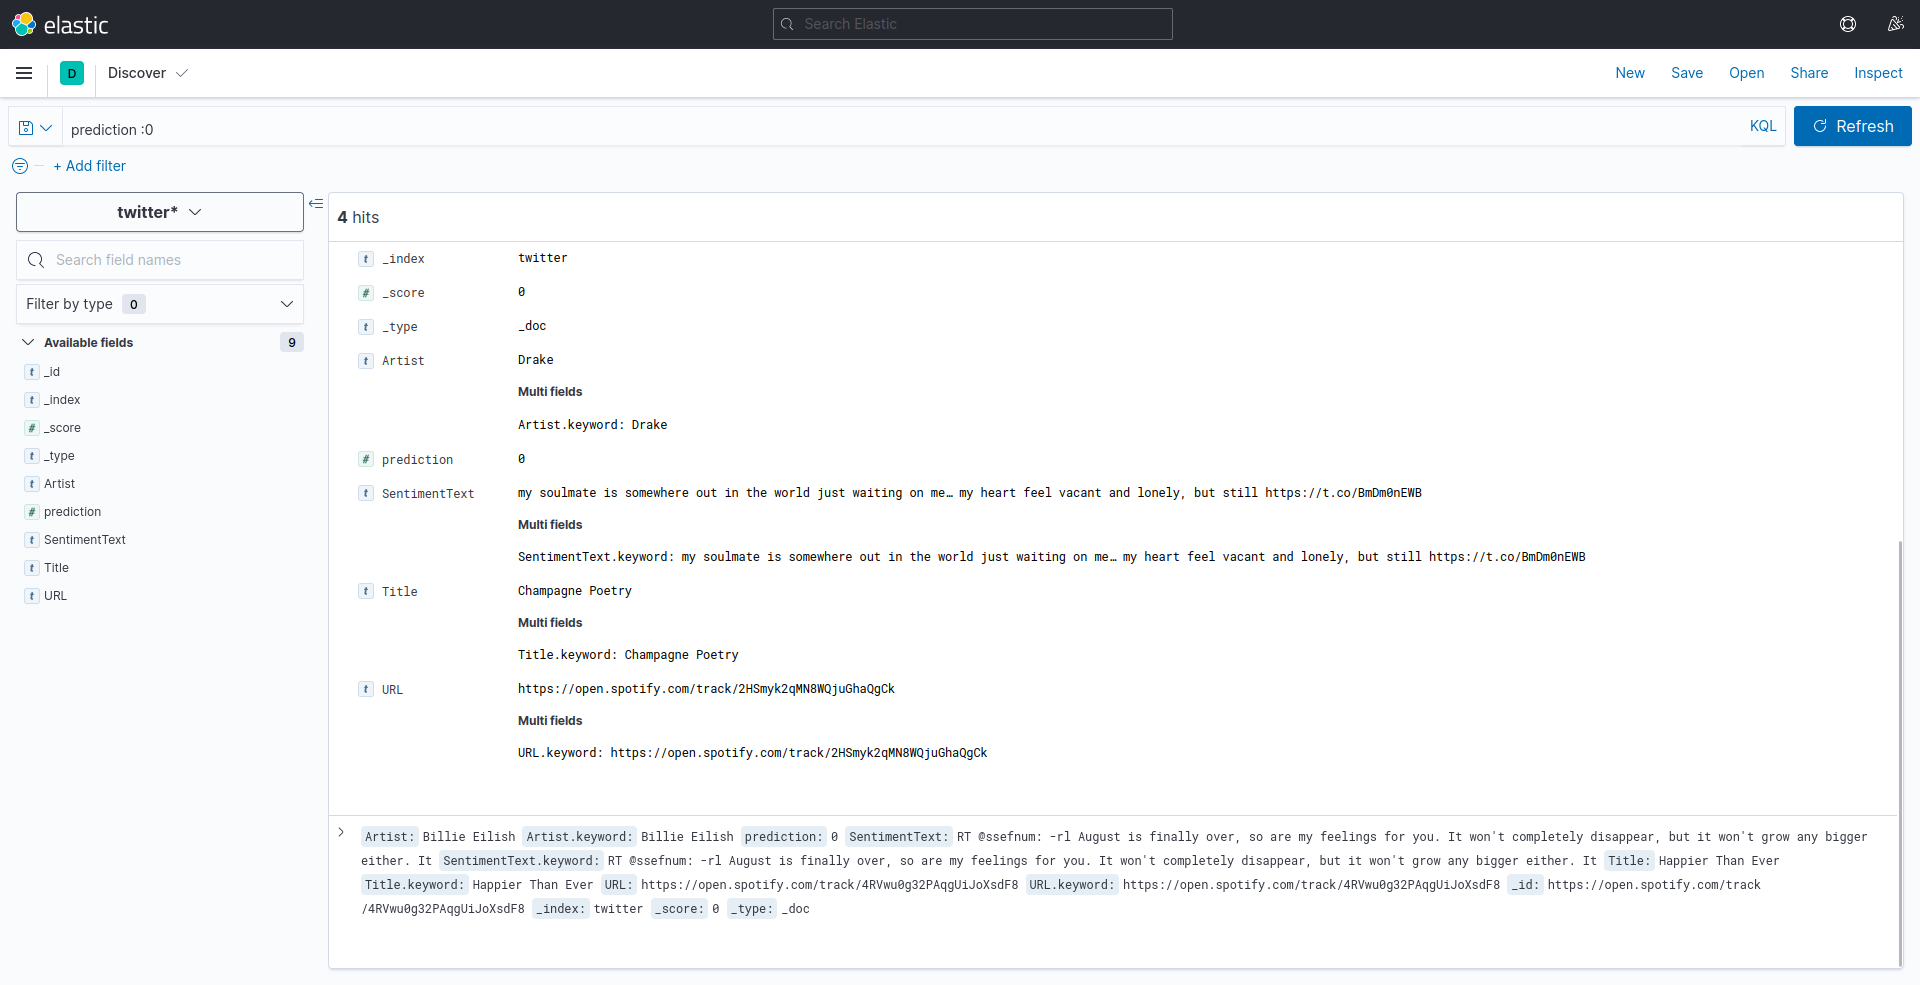
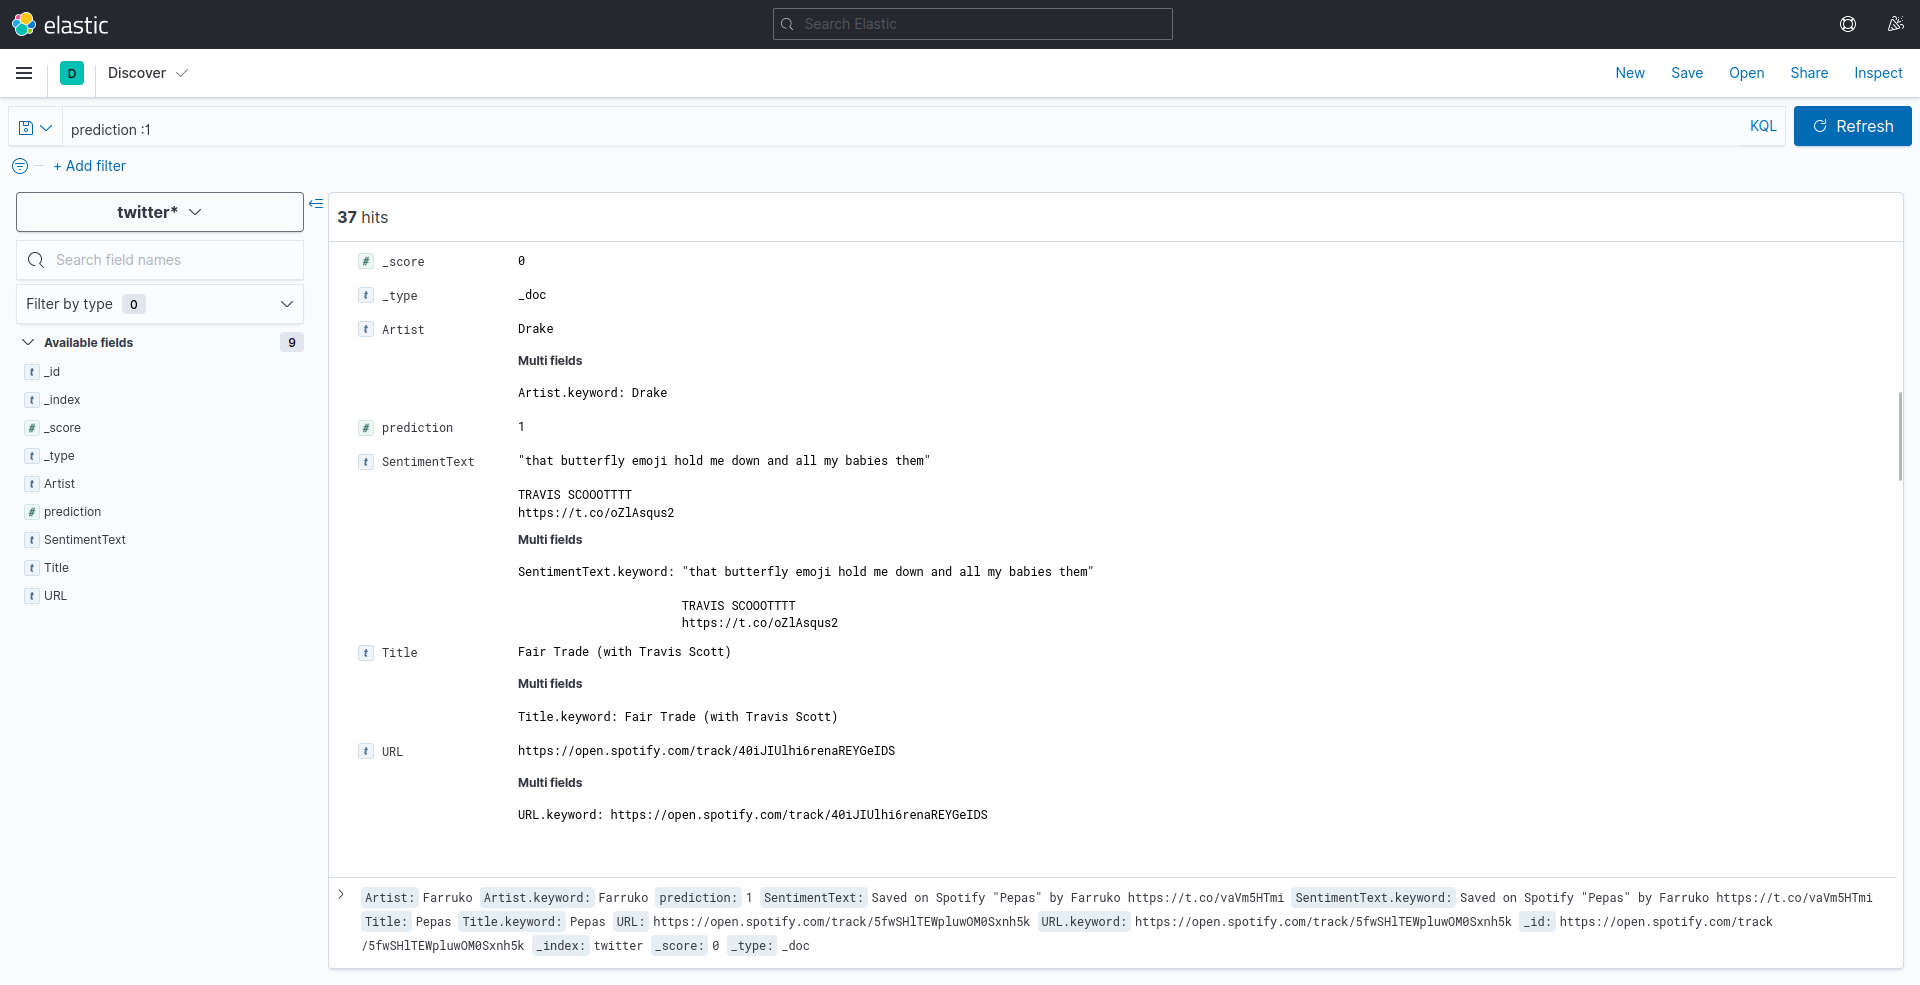

## Conclusioni

SpoTwify costituisce un piccolo esempio per dimostrare le capacità di alcune delle tecnologie studiate durante il corso Technologies for Advanced Programming.
Il progetto possiede alcune limitazioni, a partire dal modo in cui sono ottenuti i dati iniziali. Si potrebbe utilizzare il tweepy.Cursor insieme alla classe di Streaming fornita dalla stessa libreria per continuare ad ottenere nuovi tweet. Si potrebbe anche usare un dataset migliore che permetta di identificare le emozioni in essi.

Si conclude la presentazione ringraziando [TheNor01](https://github.com/TheNor01) per la pazienza avuta nell'aiutarmi a realizzare questo progetto svolgendo il ruolo di stackoverflow personale e con un piccolo meme per riassumere l'esperienza di sviluppo...

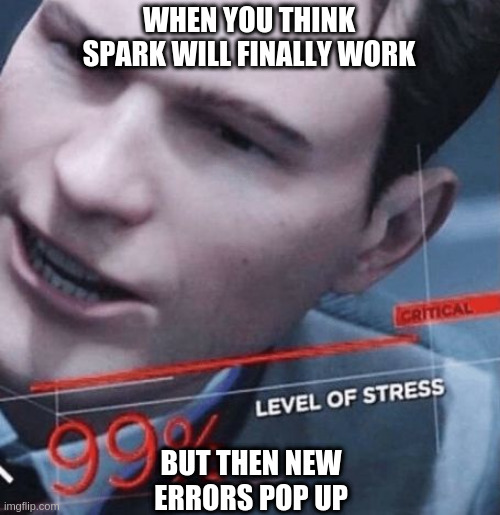